<a href="https://colab.research.google.com/github/lukekolbe/nlp_predicting-claps-on-medium-articles/blob/main/nlp_medium_article_clap_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Data Analysis for Management Support
## Term project Notebook

In this notebook we will analyze a large dataset of Blog posts scraped from the Medium platform. The goal is to use text and meta data to predict the amount of 'claps' an article might receive. 'Claps' is a metric similar to 'likes', which lets the reader express a positive reaction to the content.

For this purpose, several machine learning models are built and compared. Before any analysis can be done, thorough cleaning of text and meta data is necessary, followed by a quick exploratory analysis.

The task is a typical regression problem, with 'claps' ranging between 0 and (theoretically) infinity.

The models applied can be classified as conventional regression models based on numeric and categorical features, and language models that focus on the texts and headlines themselves, trying to identify context and patterns in the text that might explain which posts are more likely to receive more claps.

In a sense, the 'claps' variable can be seen as a proxy of quality, but also 'virality' of the content.

-----
-----

The structure of this analysis is as follows:

1.   Setup and basic data cleaning
2.   Exploratory data analysis
3.   Data Management
  *  Outlier treatment
  *  Feature engineering
  *  Text cleaning
  *  K-fold Target Encoding
4. Regression based on numeric features
5. Regression based on language models
  *  Tokenizing
  *  GloVe Embedding
  *  Simple CNN
  *  Complex CNN
6. Results and Discussion




## Initial Setup

### Configuration and Data Loading

In [ ]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import re
from sklearn.model_selection import train_test_split
from datetime import datetime
from string import ascii_letters, punctuation
import pickle

# !pip install tensorflow-gpu==2.0.0
import tensorflow as tf
os.environ['KERAS_BACKEND'] = 'tensorflow'


!pip install nltk
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

!pip install beautifulsoup4
from bs4 import BeautifulSoup

!pip install unidecode
import unidecode


### Target encoding
!pip install category_encoders
import sklearn as sk
from sklearn.linear_model import LinearRegression
from sklearn import metrics

import category_encoders as ce

#visualisation
import seaborn as sns
import matplotlib.gridspec as gridspec

color = sns.color_palette()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)


In [ ]:
# Some configuration of the plots we will create later.
%matplotlib inline  
plt.rcParams["figure.figsize"] = (20,10)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
cd '/content/drive/My Drive/ADAMS/'

/content/drive/My Drive/ADAMS


In [ ]:
# Fresh, uncleaned data
test_file = 'Test.csv'
test = pd.read_csv(test_file)

train_file = 'Train.csv'
train = pd.read_csv(train_file)

In [ ]:
## load cleaned data
test_file = 'test_cleaned.csv'
ts_a = pd.read_csv(test_file)

train_file = 'train_cleaned.csv'
tr_a = pd.read_csv(train_file)

### Data Overview

In [ ]:
print('Dimensionality of the data is {}'.format(test.shape))  # .shape returns a tupel
print('The data set has {} cases.'.format(test.shape[0]))     # we can also index the elements of that tupel
print('The total number of elements is {}.'.format(test.size))

print('Dimensionality of the data is {}'.format(train.shape))  # .shape returns a tupel
print('The data set has {} cases.'.format(train.shape[0]))     # we can also index the elements of that tupel
print('The total number of elements is {}.'.format(train.size))

Dimensionality of the data is (514, 8)
The data set has 514 cases.
The total number of elements is 4112.
Dimensionality of the data is (279577, 50)
The data set has 279577 cases.
The total number of elements is 13978850.


### Removing unwanted features and duplicates

The training data has many features that hold no information value, are redundant, or simply not present in the test data. Some test features can be infered by feature engineering, but many cannot. These are deleted from the training data. This includes the wordCount and imageCount features, as it is unclear how exactly the numbers were generated. Instead, a text-based word and image counter will be implemented later on, ensuring that counts in both train and test data are genereted via the same process.

In [ ]:
# drop duplicate posts
train = train.drop_duplicates(subset=('postId'),keep='first')

### removing non-english texts from training Data
train = train[(train['language'] == "en")]

# drop unwanted features
train = train.drop(["firstPublishedDate","language","linksCount", "wordCount", "postId","socialRecommendsCount", "recommends","subTitle", 'isSubscriptionLocked','audioVersionDurationSec','codeBlock','codeBlockCount','collectionId','createdDatetime','postCount','firstPublishedDatetime','latestPublishedDatetime','latestPublishedDate','readingTime','tagsCount','uniqueSlug','updatedDate','updatedDatetime','vote','publicationdescription','publicationdomain','publicationfacebookPageName','publicationfollowerCount','publicationname','publicationpublicEmail','publicationslug','publicationtags','publicationtwitterUsername','tag_name','slug','name','bio','userId','userName','scrappedDate', "url"],axis=1)
train.columns
#test.columns

Index(['createdDate', 'imageCount', 'responsesCreatedCount', 'text', 'title',
       'totalClapCount', 'author', 'usersFollowedByCount',
       'usersFollowedCount'],
      dtype='object')

In [ ]:
# working copies of data
tr_a = train.copy()
ts_a = test.copy()

## Exploratory Data Analysis

See Ex3

When plotting the correlation matrix, we see that the target variable 'totalClapCount' is most highly correlated to the 'responses' variable in the data. Other features are not or only loosely correlated with the target. This reduces hope that a model based on numeric or categorical features will yield precise predictions.

From the correlation plot, several strategic decisions are derived:

*   A classic OLS regression on 'responses' will serve as baseline model 
*   In addition, a more complex model including other numeric features is implemented
*   Lastly, a text based Neural Net regressor will facilitate textual information
*   Predictions from all models will serve as features in a final stacked model



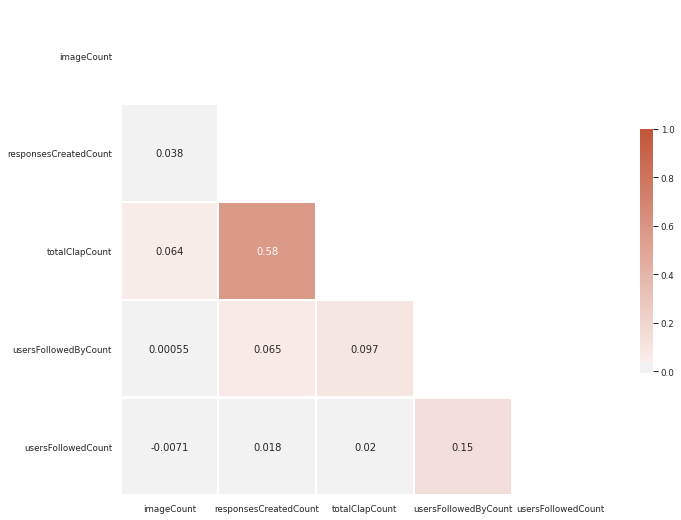

In [ ]:
# Compute the correlation matrix
corr = tr_a.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True,mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": .5})

#### Clap Distribution
Looking at the log-scaled density, we see that the distribution is highly skewed towards the right, with most observations having very few claps, and some extreme outliers. As this is problematic for most learning algorithms, correction is advisable.

Two possible strategies: 

*   Removing Outliers
*   Log-scaling target variable 'totalClapCount' (Log-Linear)
*   Standardization

Outlier removal might seem as the standard solution, the idea of predicting these outliers (the 'viral' posts) is intriguing. Removing all outliers based on interquartile range would lose a lot of information, as we assume that these outliers do not exist randomly, but for a reason. 

An alternative way to mitigate the problem in training is Log-scaling, which would yield approx. normally distributed data. It would have to be reversed after predicting on the test set, as the variable is originally unscaled and thus unscaled predictions are expected.
The problem is that there are many 0-values in the y variable. Log scaling cannot deal with these, so we'd have to add very small integer values to any 0 value. This is not ideal.

Lastly, a standardization of the data is commonly used, where the mean is subtracted from each value before dividing by the standard deviation. This yields a new variable with an expected value of 0 and a variance of one. This approach was not used, as it involved additional steps in data preparation and prediction, as one needs to make sure that any prediction is transformed back to its normal range before any interpretation is possible.

Text(0.5, 1.0, 'Density and Histogram')

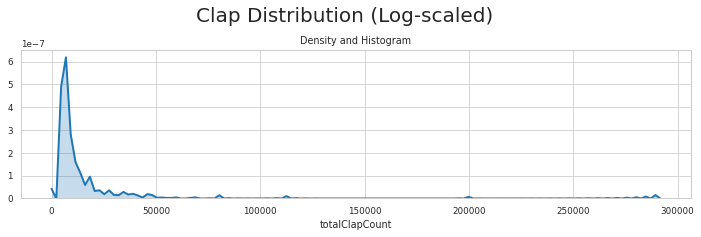

In [ ]:
plt.figure(figsize=(12,6))
plt.suptitle("Clap Distribution (Log-scaled)",fontsize=20)
gridspec.GridSpec(2,1)

tr_a.totalClapCount.describe()

plt.subplot2grid((2,1),(0,0))
sns.distplot(tr_a.totalClapCount, hist=False, color=color[0], kde_kws={"shade": True, "lw": 2}, bins=100)
plt.title("Density and Histogram")

#sns.boxplot(x=tr_a.totalClapCount)


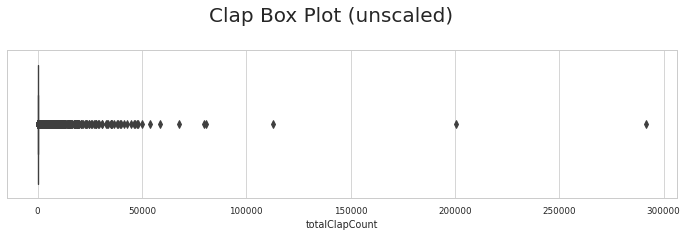

In [ ]:
plt.figure(figsize=(12,6))
plt.suptitle("Clap Box Plot (unscaled)",fontsize=20)
gridspec.GridSpec(2,1)
plt.subplot2grid((2,1),(0,0))

sns.boxplot(x=tr_a.totalClapCount)


## Data Management

### Outlier Treatment

As a compromise between wanting to find the high-attention posts and training reliable models, a modest outlier treatment is applied, where all lines where dependent variable exceeds the 3rd quartile by 8 IQR (equivalent to ~95th percentile) are removed. This is no standard procedure, as most sources recommend outlier removal beyond +- 3 IQR at most. In this sense, it is a compromise between taming the extremes in the data, while maintaining some of its original nature.

This procedure reduces the training data by about 3.000 rows, to 63.000.


Further treatments might include log-transformation (good for skewed data) or z-transformation, but these are cumbersome in use, or not suited for linear regression approaches.

In [ ]:
# Variables to be treated
#num_cols = [x for x in tr_a.columns if tr_a[x].dtype in ['float64', 'float32', 'float16', 'int64']]
# Calc 1st and 3rd quartile
tr_a.totalClapCount.quantile([0.25, 0.75, 0.95])

0.25      0.0
0.75     65.0
0.95    540.0
Name: totalClapCount, dtype: float64

In [ ]:
Q1 = tr_a.totalClapCount.quantile(0.25)
Q3 = tr_a.totalClapCount.quantile(0.75)
IQR = Q3 - Q1

tr_a['y_outlier'] = tr_a.totalClapCount > (Q3 + 8 * IQR)

tt = tr_a.copy()
tr_a = tr_a.loc[tr_a['y_outlier']==False, :].copy()


In [ ]:

#outlier_cutoff = np.percentile(tr_a['totalClapCount'], 95) # define outlier criterion

#claps = np.clip(tr_a['totalClapCount'], 0, outlier_cutoff) #claps vector without outliers (set to 0)
claps = tr_a['totalClapCount'].copy() #claps vector without outliers (set to 0)

median_score = np.mean(claps) #median without outliers #claps instead of c_vec
std_score = claps.std() #std deviation

tr_a['clap_zscore'] = ((claps - median_score)/std_score)

sns.distplot(tr_a.clap_zscore, hist=False, color=color[0], kde_kws={"shade": True, "lw": 2}, bins=100)
plt.savefig('z_score-distr.png')

-0.4731672575628428

### Feature Engineering

This section focuses on data cleaning and feature extraction. The former is a integral part of any data analysis project, the latter is important for this particular dataset, as there are substantial differences between the test and train data.

The processing aims to increase data quality and synchronize the data, leaving test and train sets with identical numeric and categorical features.

In the process, several functions are created which are then applied to the data.

#### Feature Coding

In [ ]:
# Code categories properly 

ts_a['Author'] = ts_a['Author'].astype('string')
tr_a['author'] = tr_a['author'].astype('string')

ts_a['Author'] = ts_a['Author'].str.lower()
tr_a['author'] = tr_a['author'].str.lower()

#### Feature Engineering: Text Based Features

The text itself could be a possible hint toward content success. Too long or too short articles might hinder the chances of receiving a lot of attention, as might the number of images and links. While their effect is to be tested, creating these features is not costly.

Lastly, the column 'Responses' in the test data contains valuable information regarding user comments below each article. It seems likely that this is a direct connection to post success, as many responses would indicate a lot of engagement. From the correlation plot above we can see a highly positive relationship between responses and claps. It is worthwhile to extract this feature in a numeric form.

In [ ]:
def html_counter(test, train):
  test['imageCount']= test['Text'].str.count('<img')
  test['linksCount']= test['Text'].str.count('http')-test['imageCount']

  train['imageCount']= train['text'].str.count('<img')
  train['linksCount']= train['text'].str.count('http')-train['imageCount']

  return test, train

In [ ]:
ts_a, tr_a = html_counter(ts_a, tr_a)

In [ ]:
# text and title length after processing
def text_lengths(test, train):
  test['titleLength'] = test['Header'].str.split().str.len().fillna(0) # No. of Words in the Title
  train['titleLength'] = train['title'].str.split().str.len().fillna(0) # No. of Words in the Title
  test['Length'] = test['Text'].str.split().str.len().fillna(0) # No. of Words in the Title
  train['textLength'] = train['text'].str.split().str.len().fillna(0) # No. of Words in the Title
  
  return test, train



In [ ]:
ts_a, tr_a = text_lengths(ts_a, tr_a)

In [ ]:
def response_decoder(test):
    for col in ["PublicationDetails", "Responses"]:
        test[col] = test[col].astype('string')
    
    test['Responses'] = test['Responses'].str.extract('(\d+)', expand=False)
    test['Responses']= pd.to_numeric(test['Responses'], errors='coerce')
    test['Responses'] = test['Responses'].fillna(0)

    return test

In [ ]:
ts_a = response_decoder(ts_a)

print("test info:", "\n", ts_a.info(), "\n", "\n", tr_a.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 514 entries, 0 to 513
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Unnamed: 0          514 non-null    int64  
 1   index               514 non-null    int64  
 2   Author              514 non-null    string 
 3   PublicationDetails  514 non-null    string 
 4   Responses           514 non-null    float64
 5   Header              506 non-null    object 
 6   Text                514 non-null    object 
 7   Length              514 non-null    int64  
 8   clap_zscore         114 non-null    float64
 9   imageCount          514 non-null    int64  
 10  linksCount          514 non-null    int64  
 11  titleLength         514 non-null    float64
dtypes: float64(3), int64(5), object(2), string(2)
memory usage: 48.3+ KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 63320 entries, 0 to 279572
Data columns (total 14 columns):
 #   Column              

#### Feature Engineering: Publication Details

One particular column of the test data, 'PublicationDetails', contains several pieces of information that are of interest, but cannot be used in its original text encoding. These are author, publication, and publishing date. Not lines contain all this information, but most do, and for those that don't some gaps can be filled by looking at other columns (some lines in the 'author' column contain publishing dates).

The processing results in an updated column 'author', and three date columns (year, month, day of week). Publication names were omitted, as there was little overlap between test and training data in this column.

In [ ]:
def details_entangler(test):
    # Find dates as per their standard format, seperate dates with with "¿"
    def date_finder(str): 
        s1 = re.sub('(.)(Jan |Jan-|Feb |Feb-|Mar |Mar-|Apr |Apr-|May |May-|Jun |Jun-|Jul |Jul-|Aug |Aug-|Sep |Sep-|Oct |Oct-|Nov |Nov-|Dec |Dec-)', r'\1¿\2', str) 
        return s1


    for i in range(test.shape[0]):
        test["PublicationDetails"].iloc[i] = date_finder(test["PublicationDetails"].iloc[i])

    temp = test["PublicationDetails"].str.split("¿", n = 1, expand = True) # new data frame with split value columns 
    test["AuthorInDomain"]= temp[0] # making separate first name column from new data frame 
    test["createdDate"]= temp[1] # making separate last name column from new data frame 
    del temp

    # separate author names by special character
    def author_finder(str): 
        s1 = re.sub(" in ", "¿", str, 1)
        return s1

    for i in range(test.shape[0]):
        test["AuthorInDomain"].iloc[i] = author_finder(test["AuthorInDomain"].iloc[i])

    test.loc[test["AuthorInDomain"].str.count("¿") < 1 ,"AuthorInDomain"] = test.loc[test["AuthorInDomain"].str.count("¿") < 1 ,"AuthorInDomain"] + "¿NONE"
    test["AuthorInDomain"] = test["AuthorInDomain"].str.replace('([A-Z][a-z]{2}\s\d+(,\s20\d\d)?)', 'NONE')
    temp = test["AuthorInDomain"].str.split("¿", n = 1, expand = True) 
    
    test["author"] = temp[0].str.lower()

    return test

In [ ]:
ts_a = details_entangler(ts_a)

#print("test info:", "\n", ts_a.info(), "\n", "\n", tr_a.info())

In [ ]:
def date_formatter(test, train):
    # Correct date formatting

    test['createdDate'] = test['createdDate'].fillna(test['PublicationDetails']) # filling empty dates
    test["dateTemp"] = test['createdDate'].str.find(',') # temp variable locating lines where year is missing
    
    # add year to those lines
    test.loc[test["dateTemp"]==-1, "createdDate"] = test.loc[test["dateTemp"]==-1, "createdDate"].astype(str) + ", 2019" 

    test["createdDate"] = pd.to_datetime(test["createdDate"], format='%b %d, %Y')
    train["createdDate"] = pd.to_datetime(train["createdDate"], format='%Y-%m-%d', errors='ignore')

    test['year'], test['month'], test["dayofweek"] = test['createdDate'].dt.year, test['createdDate'].dt.month, test['createdDate'].dt.dayofweek
    train['year'], train['month'], train["dayofweek"] = train['createdDate'].dt.year, train['createdDate'].dt.month, train['createdDate'].dt.dayofweek

    return test, train

In [ ]:
ts_a, tr_a= date_formatter(ts_a, tr_a)

In [ ]:
# dropping unwanted features, renaming

ts_a = ts_a.drop(["PublicationDetails","AuthorInDomain", "dateTemp"],axis=1) #drop helper variables "Author",
ts_a = ts_a.rename(columns = {'Responses': 'responses', 'Header': 'header', 'Text': 'text', 'Length': 'textLength'}, inplace = False)
tr_a = tr_a.rename(columns = {'responsesCreatedCount': 'responses'}, inplace = False)

#### Feature engineering: Author Details

In [ ]:
def author_details(test, train):
# merge test authors with training info
    df1 = pd.DataFrame(test.author.unique(), columns=['author']) 
    df2 = pd.DataFrame(train[["author", "usersFollowedByCount", "usersFollowedCount"]])
    df2 = df2.drop_duplicates(subset=('author'),keep='first')

    inner_join = pd.merge(df1, 
              df2, 
              on ='author', 
              how ='inner')

    df3 = test.author
    left_join = pd.merge(df3, 
              inner_join, 
              on ='author', 
              how ='left') 

    test["usersFollowedByCount"] = left_join["usersFollowedByCount"].fillna(0)
    test["usersFollowedCount"] = left_join["usersFollowedCount"].fillna(0)

    return test, train

In [ ]:
ts_a, tr_a = author_details(ts_a, tr_a)

In [ ]:
# After Author based feature Engineering encode as category
for col in ['author', 'year', 'month', 'dayofweek']:
    ts_a[col] = ts_a[col].astype('category')
    tr_a[col] = tr_a[col].astype('category')
    
print(ts_a.columns, "\n","\n", tr_a.columns)


Index(['level_0', 'Unnamed: 0', 'Author', 'responses', 'header', 'text',
       'textLength', 'imageCount', 'linksCount', 'titleLength', 'createdDate',
       'author', 'year', 'month', 'dayofweek', 'usersFollowedByCount',
       'usersFollowedCount', 'author_Encoded', 'year_Encoded', 'month_Encoded',
       'dayofweek_Encoded'],
      dtype='object') 
 
 Index(['createdDate', 'imageCount', 'responses', 'text', 'title',
       'totalClapCount', 'author', 'usersFollowedByCount',
       'usersFollowedCount', 'y_outlier', 'clap_zscore', 'linksCount',
       'titleLength', 'textLength', 'year', 'month', 'dayofweek'],
      dtype='object')


In [ ]:
#Checkpoint

#save
tr_a.to_csv('train_cleaned1.csv')
ts_a.to_csv('test_cleaned1.csv')

#load
#tr_a = pd.read_csv('train_cleaned1.csv')
#ts_a = pd.read_csv('test_cleaned1.csv')

### Text Cleaning

In preparation of fitting Neural Net models on the text data, several steps are undertaken. After defining lists of stop words and contractions to delete/replace, cleaner functions are defined for: 

*   removing any non-text characters
*   lowercasing of all text
*   removing URLs
*   removing HTML code

Having removed noise in the text data makes it quicker to process and more easily interpretable for the encoder. 

Lemmatizing is *not* done with this data. It is a costly process that might increase quality, but since the text corpus is large, there will likely be enough data to create meaningful embeddings. 

#### Contraction and Stop Word Lists

In [ ]:
contraction_mapping = { 
    "ain't": "is not", "aren't": "are not", 
    "can't": "cannot",     "'cause": "because", 
    "could've": "could have",     "couldn't": "could not",
    "didn't": "did not",     "doesn't": "does not", 
    "don't": "do not",     "hadn't": "had not", 
    "hasn't": "has not",     "haven't": "have not",
    "he'd": "he would",     "he'll": "he will", 
    "he's": "he is",     "how'd": "how did", 
    "how'd'y": "how do you",     "how'll": "how will", 
    "how's": "how is",    "I'd": "I would", 
    "I'd've": "I would have",     "I'll": "I will", 
    "I'll've": "I will have",     "I'm": "I am", 
    "I've": "I have",     "i'd": "i would",
    "i'd've": "i would have",     "i'll": "i will", 
    "i'll've": "i will have",     "i'm": "i am", 
    "i've": "i have",     "isn't": "is not", 
    "it'd": "it would",    "it'd've": "it would have", 
    "it'll": "it will",    "it'll've": "it will have", 
    "it's": "it is",     "let's": "let us", 
    "ma'am": "madam",    "mayn't": "may not", 
    "might've": "might have",     "mightn't": "might not", 
    "mightn't've": "might not have",     "must've": "must have",
    "mustn't": "must not",     "mustn't've": "must not have", 
    "needn't": "need not",     "needn't've": "need not have", 
    "o'clock": "of the clock",    "oughtn't": "ought not", 
    "oughtn't've": "ought not have",     "shan't": "shall not", 
    "sha'n't": "shall not",     "shan't've": "shall not have",
    "she'd": "she would",     "she'd've": "she would have", 
    "she'll": "she will",     "she'll've": "she will have", 
    "she's": "she is",    "should've": "should have", 
    "shouldn't": "should not",     "shouldn't've": "should not have", 
    "so've": "so have",     "so's": "so as",
    "this's": "this is",    "that'd": "that would", 
    "that'd've": "that would have",     "that's": "that is", 
    "there'd": "there would",    "there'd've": "there would have", 
    "there's": "there is",     "here's": "here is", 
    "they'd": "they would",    "they'd've": "they would have",
    "they'll": "they will",    "they'll've": "they will have", 
    "they're": "they are",     "they've": "they have", 
    "to've": "to have",    "wasn't": "was not", 
    "we'd": "we would",    "we'd've": "we would have", 
    "we'll": "we will",    "we'll've": "we will have", 
    "we're": "we are",    "we've": "we have", 
    "weren't": "were not",     "what'll": "what will", 
    "what'll've": "what will have",     "what're": "what are",
    "what's": "what is",     "what've": "what have", 
    "when's": "when is",     "when've": "when have", 
    "where'd": "where did",     "where's": "where is",
    "where've": "where have",     "who'll": "who will", 
    "who'll've": "who will have",     "who's": "who is", 
    "who've": "who have",    "why's": "why is", 
    "why've": "why have",    "will've": "will have", 
    "won't": "will not",     "won't've": "will not have",
    "would've": "would have",     "wouldn't": "would not", 
    "wouldn't've": "would not have",     "y'all": "you all",
    "y'all'd": "you all would",     "y'all'd've": "you all would have", 
    "y'all're": "you all are",     "y'all've": "you all have",
    "you'd": "you would",     "you'd've": "you would have", 
    "you'll": "you will",     "you'll've": "you will have",
    "you're": "you are",     "you've": "you have"}

In [ ]:
# basic stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words("english")

#### Cleaning functions

In [ ]:
def cleaner_passover(text):
  """Operator function for initial text cleaning."""
  
  punct_re_string = '|'.join('\\' + char for char in punctuation)
  punct_re_string = r'['+punct_re_string+']'
  hyphen_unicode_list = '[\u002D\u058A\u05BE\u1400\u1806\u2010-\u2015\u2E17\u2E1A\u2E3A\u2E3B\u2E40\u301C\u3030\u30A0\uFE31\uFE32\uFE58\uFE63\uFF0D]'
  space_unicode_list = '[\u00A0\u1680​\u180e\u2000-\u2009\u200a​\u200b​\u202f\u205f​\u3000]'

  text = text.lower()
  text = unidecode.unidecode(text)
  
  text = ' '.join([contraction_mapping[word] if word in contraction_mapping else word for word in text.split(' ')]) #expand contractions
  text = ' '.join([word for word in text.split(' ') if word not in stop_words]) #remove stopwords
  text = text.replace('&', ' and ')
  text = text.replace('@', ' at ')
  text = re.sub(r'\s' + re.escape(hyphen_unicode_list) + '\s', ' ', text)
  text = re.sub(re.escape(hyphen_unicode_list), ' ', text)
  text = re.sub(r'\s' + re.escape(space_unicode_list) + '\s', ' ', text)
  text = re.sub(re.escape(space_unicode_list), ' ', text)
  text = text.replace("'", ' ')
  text = text.replace(",", ' ')
  text = text.replace(".", ' ')
  text = re.sub(punct_re_string, ' ', text)

  text = re.sub(r'\w*\d+\w*', ' ', text)
  text = re.sub(r'\d', ' ', text)
  text = re.sub(r'\b\w\b',' ', text) #remove remaining single characters

  text = re.sub('\s\s+' , ' ', text)
    
  return text

In [ ]:
def cleaning_handler(col, row, df_length):
  """Handler for cleaning functions."""
  
  #row[col] = str(row[col])

  row[col] = re.sub(r'<[^>]+>','', row[col])
  #row[col] = BeautifulSoup(row[col]).text
  row[col] = re.sub(r'[/\r?\n|\r/]', ' ', row[col])
  row[col] = re.sub(r'(?<![A-Z])(?<!^)([A-Z])',r' \1', row[col]) 
  row[col] = re.sub(r'https?:\/\/[^\s]*\s', ' ', row[col])
  row[col] = re.sub(r'www[^\s]*\s', ' ', row[col])
  row[col] = re.sub(r'\s[^\s]*.com[\s\.]', ' ', row[col])

  row[col] = cleaner_passover(row[col])
  
  print(f'\rcompleted: {row.name + 1} of {df_length}', end='')
  return row

#### Run cleaning

In [ ]:
ts_a = ts_a.reset_index()
ts_a = ts_a.drop('index', axis=1)
ts_a = ts_a.apply(lambda row: cleaning_handler("text",row, len(ts_a)), axis=1)

completed: 514 of 514

In [ ]:
# CLEANING TRAIN
tr_a = tr_a.reset_index()
tr_a = tr_a.drop('index', axis=1)
tr_a = tr_a.apply(lambda row: cleaning_handler("text",row, len(tr_a)), axis=1)

completed: 63320 of 63320

### Final Data Prep, Training splits

#### Train, Val splitting

In [ ]:
tr, val = train_test_split(tr_a, random_state = 2020, test_size=.2, 
                           stratify = pd.qcut(claps.values, 10, duplicates = 'drop'))

tr_data = tr.copy()
val_data = val.copy()


### Encoding categorical variables

After excessive pre-processing, several categorical variables have been added to the data. Fitting a model on this data can be difficult, as most models cannot deal with non-numeric features that are not ordinally scaled.

One possible way to deal with this issue include **one-hot encoding** (many sparse vectors of zeros and ones, one for each factor level). This creates a very large dataframe that is cumbersome to use.


Another promising approach is to train an **embedding** for factor variables that can be used as input to a neural network. For data with many categorical features, this might be an interesting strategy. Due to time constraints, this is outsite the scope of this project.

Example for Embedding Encoding:
https://machinelearningmastery.com/how-to-prepare-categorical-data-for-deep-learning-in-python/




----
----

The option applied here is **Target Encoding**, where each factor level is encoded in a way that the mean target value for each factor level is inserted. This links the factor levels to the target and thus provides explanative value, but it is a possible source for target leaking.
In order to avoid overfitting, 5-fold cross-validation is used for encoding.

At this point, the training data is split into the training set and the validation set. The target encoder ist trained on the training set, and the values are then merged into the validation and test sets. For factor levels in test or val with no match in the training data, the overall median of the dependent variable ('totalClapCount') is imputed.

_DISCLAIMER_: The code for k-fold target encoding was sourced externally from https://github.com/pourya-ir/Medium/blob/master/K-fold-target-enc/K-fold-Target-Encoding.ipynb




#### k-fold Target Encoding

In [ ]:
from sklearn import base
from sklearn.model_selection import KFold

class KFoldTargetEncoderTrain(base.BaseEstimator, base.TransformerMixin):

    def __init__(self, colnames,targetName,n_fold=5,verbosity=True,discardOriginal_col=False):

        self.colnames = colnames
        self.targetName = targetName
        self.n_fold = n_fold
        self.verbosity = verbosity
        self.discardOriginal_col = discardOriginal_col

    def fit(self, X, y=None):
        return self


    def transform(self,X):

        assert(type(self.targetName) == str)
        assert(type(self.colnames) == str)
        assert(self.colnames in X.columns)
        assert(self.targetName in X.columns)

        mean_of_target = X[self.targetName].mean()
        kf = KFold(n_splits = self.n_fold, shuffle = True, random_state=2020)
        

        col_mean_name = self.colnames + '_' + 'Encoded'
        X[col_mean_name] = np.nan

        for tr_ind, val_ind in kf.split(X):
            X_tr, X_val = X.iloc[tr_ind], X.iloc[val_ind]
            X.loc[X.index[val_ind], col_mean_name] = X_val[self.colnames].map(X_tr.groupby(self.colnames)[self.targetName].mean())

        X[col_mean_name].fillna(mean_of_target, inplace = True)

        if self.verbosity:

            encoded_feature = X[col_mean_name].values
            print('Correlation between the new feature, {} and, {} is {}.'.format(col_mean_name,
                                                                                      self.targetName,
                                                                                      np.corrcoef(X[self.targetName].values, encoded_feature)[0][1]))
        if self.discardOriginal_col:
            X = X.drop(self.targetName, axis=1)
            

        return X

In [ ]:
cols = tr_data[["author", "year", "month", "dayofweek"]].columns

for i in cols:
    targetc = KFoldTargetEncoderTrain(i,'totalClapCount',n_fold=5)
    tr_data = targetc.fit_transform(tr_data)

Correlation between the new feature, author_Encoded and, totalClapCount is 0.5013132154068669.
Correlation between the new feature, year_Encoded and, totalClapCount is 0.011056667350987398.
Correlation between the new feature, month_Encoded and, totalClapCount is 0.038629825745740545.
Correlation between the new feature, dayofweek_Encoded and, totalClapCount is 0.015420621988429976.


In [ ]:
class KFoldTargetEncoderTest(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self,train,colNames,encodedName):
        
        self.train = train
        self.colNames = colNames
        self.encodedName = encodedName
        
        
    def fit(self, X, y=None):
        return self

    def transform(self,X):


        #mean = self.train[[self.colNames,self.encodedName]].groupby(self.colNames).mean().reset_index() 
        mean = self.train[[self.colNames,self.encodedName]].groupby(self.colNames).mean().reset_index() 
        
        dd = {}
        for index, row in mean.iterrows():
            dd[row[self.colNames]] = row[self.encodedName]

        
        X[self.encodedName] = X[self.colNames]
        X = X.replace({self.encodedName: dd})

        return X

In [ ]:
#cols = tr_data[["author", "year", "month", "dayofweek"]].columns
cols2 = tr_data[tr_data.columns[-4:]].columns

# Match encoded variables with test data
for i, j in zip(cols, cols2):
    test_targetc = KFoldTargetEncoderTest(tr_data,i,j)
    ts_a = test_targetc.fit_transform(ts_a)

## Where there is no match of authors between test and train, we have to manually impute the mean
median = tr_a.totalClapCount.median()
ts_a["author_Encoded"] = pd.to_numeric(ts_a.author_Encoded, errors='coerce')
ts_a["author_Encoded"] = ts_a["author_Encoded"].fillna(median)

# Match encoded variables with validation data
for i, j in zip(cols, cols2):
    test_targetc = KFoldTargetEncoderTest(tr_data,i,j)
    val_data = test_targetc.fit_transform(val_data)

val_data["author_Encoded"] = pd.to_numeric(val_data.author_Encoded, errors='coerce')
val_data["author_Encoded"] = val_data["author_Encoded"].fillna(median)


### Checkpoint

In [ ]:
#tr, tune = train_test_split(tr_data, random_state = 2020, test_size=.2)
#tr_data = tr.copy()
#tune_data = tune.copy()

#del tr, tune

In [ ]:
# Mini splits for quick training

tr_mini = tr_data.copy().sample(n = 10000) 
val_mini = val_data.copy().sample(n = 1500) 

In [ ]:
#save
tr_a.to_csv('train_cleaned2.csv')
ts_a.to_csv('test_cleaned2.csv')

tr_data.to_csv('train_data.csv')
val_data.to_csv('val_data.csv')
#tune_data.to_csv('tune_data.csv')

tr_mini.to_csv('train_mini_data.csv')
val_mini.to_csv('val_mini_data.csv')

In [ ]:
#load
tr_a = pd.read_csv('train_cleaned2.csv')
ts_a = pd.read_csv('test_cleaned2.csv')

tr_data = pd.read_csv('train_data.csv')
val_data = pd.read_csv('val_data.csv')

#tr_mini = pd.read_csv('train_mini_data.csv')
#val_mini = pd.read_csv('val_mini_data.csv')

ts_a

## Numeric-based regression models



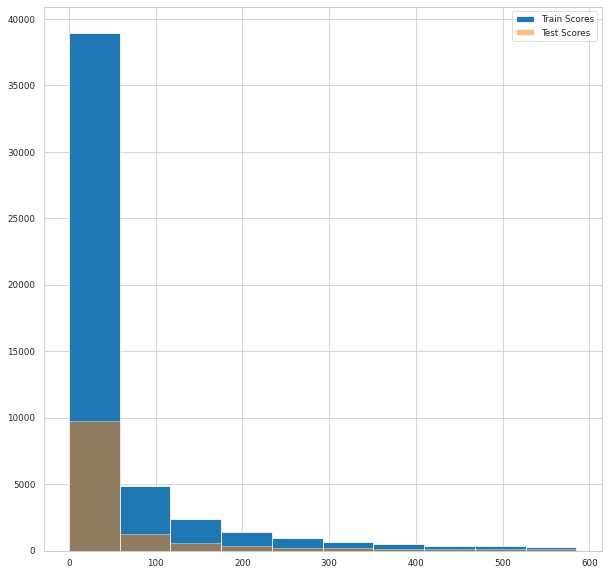

In [ ]:
target= "totalClapCount"

train_y = tr_data[target]
val_y = val_data[target]

test = ts_a[["responses", "imageCount", "usersFollowedByCount", "usersFollowedCount", "linksCount","titleLength", "textLength", "author_Encoded", "year_Encoded", "month_Encoded", "dayofweek_Encoded"]].copy()
features = ["responses", "imageCount", "usersFollowedByCount", "usersFollowedCount", "linksCount","titleLength", "textLength", "author_Encoded", "year_Encoded", "month_Encoded", "dayofweek_Encoded"]

fig, ax1 = plt.subplots(1, 1, figsize = (10, 10))
ax1.hist(train_y, 10, label = 'Train Scores')
ax1.hist(val_y, 10, label = 'Test Scores', alpha = 0.5)
ax1.legend()
plt.savefig('y_scaled-histogram.png')

test_predictions = pd.DataFrame()
#test_predictions = pd.read_csv('test_predictions.csv')

mae = list()
#maetxt = open("mae.txt", "r")
#mae= maetxt.read()


### Baseline Linear Model

In order to compare results of different models, a baseline is created. Since the highest correlation in the initial data was found in the "responses" variable, this is used as a baseline. 

A simple linear regression model ist created that only uses the response variable for prediction. 

Comparisons and, ultimately, model decisions are drawn on the basis of the mean absolute error (MAE). This metric is commonly used, as it has a rather intuitive interpretation: it measures the average magnitude of the errors in a set of predictions, without considering their direction. It’s the average over the test sample of the absolute differences between prediction and actual observation where all individual differences have equal weight.

The Baseline model yields an MAE of 58.4. Any further model is compared to this metric.

In [ ]:
#OLS on Responses only

#val_y = val_data['totalClapCount']

features = ["responses"]
#features = ["responses", "imageCount", "usersFollowedByCount", "usersFollowedCount", "linksCount","titleLength", "textLength", "author_Encoded", "year_Encoded", "month_Encoded", "dayofweek_Encoded"]

X = tr_data[features]
X_val = val_data[features]
x_test = test[features]

regressor = LinearRegression()  
regressor.fit(X, train_y) #training the algorithm

y_pred = regressor.predict(X_val)
val_data['pred_claps_baseline'] = y_pred

print('Baseline MAE:', metrics.mean_absolute_error(val_y, y_pred))
error = metrics.mean_absolute_error(val_y, y_pred)

mae.append(("Baseline MAE", error))

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regressor.coef_))], axis = 1)
coefficients

### Extracting prediction on test Data
test_predictions_OLS = regressor.predict(x_test)
test_predictions["baseline"] = test_predictions_OLS


Baseline MAE: 58.44764288786726


In [ ]:
#OLS on all features

#val_y = val_data['totalClapCount']

#features = ["responses"]
features = ["responses", "imageCount", "usersFollowedByCount", "usersFollowedCount", "linksCount","titleLength", "textLength", "author_Encoded", "year_Encoded", "month_Encoded", "dayofweek_Encoded"]

X = tr_data[features]
X_val = val_data[features]
x_test = test[features]

regressor = LinearRegression()  
regressor.fit(X, train_y) #training the algorithm

y_pred = regressor.predict(X_val)
val_data['pred_claps_linear'] = y_pred


print('OLS MAE:', metrics.mean_absolute_error(val_y, y_pred))

error = metrics.mean_absolute_error(val_y, y_pred)
mae.append(("Linear Regression MAE", error))

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regressor.coef_))], axis = 1)
coefficients

### Extracting prediction on test Data
test_predictions_OLS = regressor.predict(x_test)
test_predictions["linear"] = test_predictions_OLS

OLS MAE: 44.362656646638214


### Stacking Ensemble

In an effort to further decrease the error, a stacking ensemble is set up. It combines predictions of several regression models (KNN, Decision Trees) and uses these as features in a final meta model (CV Ridge Regression). The idea is that a stacked model can harness the capabilities of a range of well-performing regression models and make predictions that have better performance than any single model in the ensemble.

Given that the data is rather weak in its predictive value, it is interesting to see whether such an approach can help with predictions.

The results are promising, as the stacked model has the lowest MAE. Unfortunately due to time constraints, the stack is rather small. Adding further models such as SVMs to the stack, or using a more sophisticated meta model (e.g. a large random forest) would likely improve performance further.

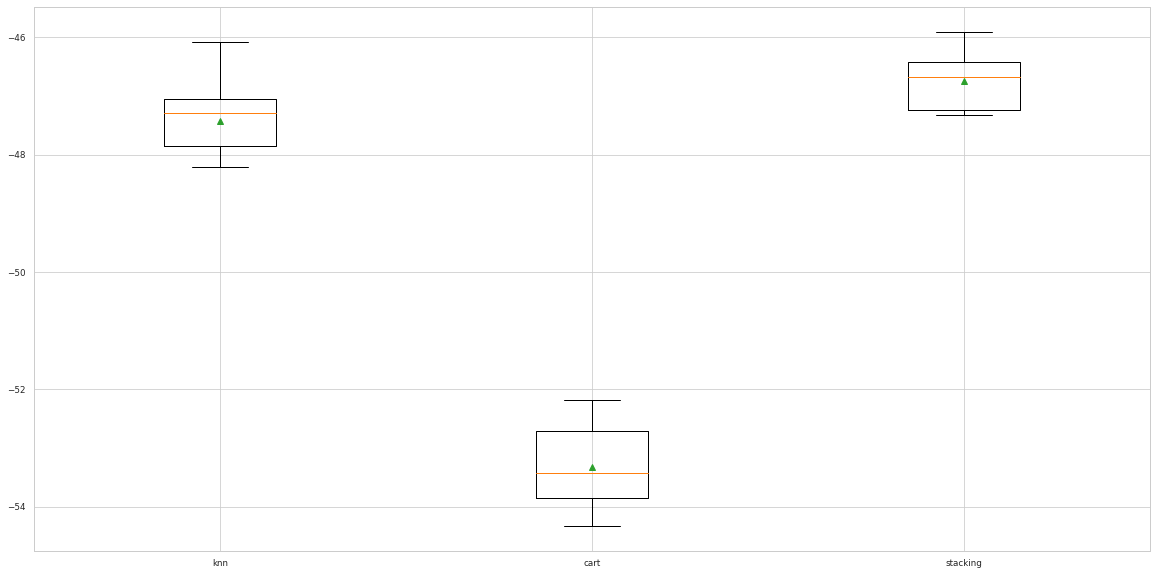

In [ ]:
### Stacking Model

# compare ensemble to each standalone models for regression
from numpy import mean
from numpy import std
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import StackingRegressor
from matplotlib import pyplot

y = tr_data[target]
X = tr_data[features]
val = val_data[features]

# get a stacking ensemble of models
def get_stacking():
		# define the base models
		level0 = list()
		level0.append(('knn', KNeighborsRegressor()))
		level0.append(('cart', DecisionTreeRegressor()))
		#level0.append(('svm', SVR()))
		#level0.append(('lr', RidgeCV()))


		# define meta learner model
		#level1 = LinearRegression()
		level1 = RidgeCV()

		# define the stacking ensemble
		model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
		return model

# get a list of models to evaluate
def get_models():
		models = dict()
		models['knn'] = KNeighborsRegressor()
		models['cart'] = DecisionTreeRegressor()
		#models['svm'] = SVR()
		#models['lr'] = RidgeCV()
		models['stacking'] = get_stacking()
		return models

# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
		cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1)
		scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1, error_score='raise')
		return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	scores = evaluate_model(model, X, y)
	results.append(scores)
	names.append(name)
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))

# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()
plt.savefig('stack_comparison.png')



## Fitting the model for prediction
#model.fit(X, y.values.ravel())

#y_pred = model.predict(val)
#print('Predicted Value: %.3f' % (y_pred))
#print('Stacking Ensemble MAE:', metrics.mean_absolute_error(val_y, y_pred)) 




In [ ]:
### fit model for prediction

y = tr_data[target]
X = tr_data[features]
x_test = test[features]

# define the base models
level0 = list()
level0.append(('knn', KNeighborsRegressor()))
level0.append(('cart', DecisionTreeRegressor()))
# define meta learner model
level1 = RidgeCV()

# define the stacking ensemble
model = StackingRegressor(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X, y)

### Extracting prediction on test Data
test_predictions_stack = model.predict(x_test)
test_predictions["stack"] = test_predictions_stack
print(test_predictions)

     Unnamed: 0      baseline       linear    miniCNN       stack
0             0  11925.742588  8863.408011  47.466293  268.755283
1             1   3000.265492  2155.761287  37.669350  153.851006
2             2   3379.266643  2521.084323  22.881779  222.461128
3             3   1408.460660   977.399136  42.054787  155.255167
4             4    404.107611   289.836423  35.079487  148.558397
..          ...           ...          ...        ...         ...
509         509   3474.016931  2559.949675  41.813400  160.223739
510         510    498.857899   484.274815  62.019775  219.198526
511         511    498.857899 -1472.864904  30.609410  158.492773
512         512   2242.263191  1641.677255  26.714950  149.854546
513         513    688.358474   512.331273  27.996592  148.882434

[514 rows x 5 columns]


## Language Model

The models in this section only use text data from the articles. The tokens are embedded usind a GloVe Embedding, resulting in a vocabulary of 194.000 words.

Two CNN models are applied, one simple with one convolutional layer, and a more sophisticated model with multiple layers and dropout for overfitting prevention.

CNNs have shown to be efficient in certain text based regression applications (https://www.aclweb.org/anthology/P15-2030/). With their filter kernels they are suited for context detection in the data.

Both models use ReLu activation functions throughout in order to not limit predictions to 1.

The first model ist trained with a 200d embedding, resulting in 39,665,133 total parameters.

The complexity of the second model comes with a dramatic increase in processing time. This is reflected in a reduced embedding size for training in order to reduce parameters to 19,850,133 and save time. 

The time consumption of model training using large embeddings are only acceptable if the results improve significantly.

In [ ]:
# Importing libraries
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Embedding, Input, Flatten
from keras.layers import Conv1D, GlobalMaxPool1D, MaxPooling1D,Dropout, concatenate
from keras.preprocessing import text, sequence

from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras import optimizers
from keras import initializers
from keras import losses

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline

### Model setup

In [ ]:
# define network parameters
max_features = 20000 ##20000
maxlen = 200 ##100
text_field = 'text'


In [ ]:
#list_sentences_full = tr_data["text"].fillna("Invalid").values

list_sentences_train = tr_data["text"].fillna("Invalid").values
list_sentences_val = val_data["text"].fillna("Invalid").values
list_sentences_test = ts_a["text"].fillna("Invalid").values

#list_sentences_train = tr_mini["text"].fillna("Invalid").values
#list_sentences_val = val_mini["text"].fillna("Invalid").values


#### Tokenizer

In [ ]:
article_tokeniser = text.Tokenizer(num_words=max_features,lower=False)

article_tokeniser.fit_on_texts(list_sentences_train) # list_sentences_full or list_sentences_train for small vocabulary

# train
train_sequences_article = article_tokeniser.texts_to_sequences(list_sentences_train)
texts_tr = sequence.pad_sequences(train_sequences_article, maxlen=maxlen) #, padding='post'

# val
val_sequences_article = article_tokeniser.texts_to_sequences(list_sentences_val)
texts_val = sequence.pad_sequences(val_sequences_article, maxlen=maxlen) #, padding='post'

# test (for final prediction)
test_sequences_article = article_tokeniser.texts_to_sequences(list_sentences_test)
texts_test = sequence.pad_sequences(test_sequences_article, maxlen=maxlen) #, padding='post'

# Vocabulary size
article_vocabulary = article_tokeniser.word_index
article_vocabulary_size = len(article_tokeniser.word_index) + 1
print(f'article vocabulary size: {article_vocabulary_size}')

article vocabulary size: 194228


In [ ]:


### Article

with open('tokenizer_article.pkl', 'wb') as article_tokeniser_out:
    pickle.dump(article_tokeniser, article_tokeniser_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('train_sequences_article.pkl', 'wb') as train_sequences_article_out:
    pickle.dump(train_sequences_article, train_sequences_article_out, protocol=pickle.HIGHEST_PROTOCOL)
    
with open('val_sequences_article.pkl', 'wb') as val_sequences_article_out:
    pickle.dump(val_sequences_article, val_sequences_article_out, protocol=pickle.HIGHEST_PROTOCOL)

with open('test_sequences_article.pkl', 'wb') as test_sequences_article_out:
    pickle.dump(test_sequences_article, test_sequences_article_out, protocol=pickle.HIGHEST_PROTOCOL)


### LOADING
with open('tokenizer_article.pkl', 'rb') as article_tokeniser_in:
    article_tokeniser = pickle.load(article_tokeniser_in)
    article_vocabulary = article_tokeniser.word_index
    article_vocabulary_size = len(article_tokeniser.word_index) + 1

with open('train_sequences_article.pkl', 'rb') as train_sequences_article_in:
    train_sequences_article = pickle.load(train_sequences_article_in)

with open('test_sequences_article.pkl', 'rb') as test_sequences_article_in:
    test_sequences_article = pickle.load(test_sequences_article_in)

#### GloVe Embedding

https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/

In [ ]:
#!wget http://nlp.stanford.edu/data/glove.6B.zip

#import zipfile
#zip_ref = zipfile.ZipFile('/content/drive/My Drive/ADAMS/glove.6B.zip', 'r')
#zip_ref.extractall('/content/drive/My Drive/ADAMS/GloVe/')
#zip_ref.close()

In [ ]:
# Load embedding
embeddings_index = {}
with open('GloVe/glove.6B.100d.txt') as glove_in:
    for line in glove_in:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, 'f', sep=' ')
        embeddings_index[word] = coefs


In [ ]:
count_words = article_vocabulary_size
embedding_matrix = np.zeros((count_words, 100))
for word, i in article_vocabulary.items():
    if i >= article_vocabulary_size:
        continue

    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Language Model Training

#### Simple CNN

In [ ]:
embed_size = 200

target= "totalClapCount"
#target = "clap_zscore"

train_y = tr_data[target]
val_y = val_data[target]



embedding_layer = Embedding(count_words, embed_size,
                    embeddings_initializer=initializers.Constant(embedding_matrix),
                    input_length=maxlen,trainable=False)

model = Sequential() # initilaizing the Sequential nature for CNN model
model.add(embedding_layer)
model.add(Conv1D(32, 3, padding='same', activation='relu'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(250, activation='relu'))
model.add(Dense(1, activation='relu'))

model.compile(loss='mse', optimizer='adam', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 200, 200)          38845400  
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 200, 32)           19232     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 100, 32)           0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 3200)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 250)               800250    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 251       
Total params: 39,665,133
Trainable params: 819,733
Non-trainable params: 38,845,400
___________________________________

In [ ]:
# Training

batch_size = 500
epochs = 3

file_path="weights_simple.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='mean_absolute_error', save_freq=50, verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="mean_absolute_error", mode="min", patience=5)

callbacks_list = [checkpoint, early] #early
model.fit(texts_tr, train_y, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.2, 
          callbacks=callbacks_list)

Epoch 1/3
49/82 [================>.............] - ETA: 11s - loss: 9332.1465 - mean_absolute_error: 61.2025
Epoch 00001: mean_absolute_error improved from inf to 61.10183, saving model to weights_simple.hdf5
82/82 [==============================] - 71s 866ms/step - loss: 9110.4189 - mean_absolute_error: 60.6514 - val_loss: 8838.4590 - val_mean_absolute_error: 56.4862
Epoch 2/3
17/82 [=====>........................] - ETA: 24s - loss: 9286.4043 - mean_absolute_error: 60.8503
Epoch 00002: mean_absolute_error improved from 61.10183 to 60.64757, saving model to weights_simple.hdf5
67/82 [=======================>......] - ETA: 15s - loss: 8746.5342 - mean_absolute_error: 59.4405
Epoch 00002: mean_absolute_error improved from 60.64757 to 59.43910, saving model to weights_simple.hdf5
82/82 [==============================] - 119s 1s/step - loss: 8680.0039 - mean_absolute_error: 59.0304 - val_loss: 8623.1533 - val_mean_absolute_error: 61.8959
Epoch 3/3
35/82 [===========>..................] - 

In [ ]:
model.load_weights(file_path)
model.save('simple_model.h5')

##### Evaluate & Predict

simple CNN MAE: 57.966375552010895


count    12664.000000
mean        48.434303
std         25.925753
min          0.000000
25%         31.654070
50%         47.481936
75%         64.380688
max        172.191666
Name: pred_claps_miniCNN, dtype: float64

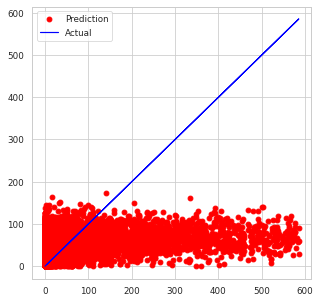

In [ ]:
model.evaluate(texts_val, val_y)

val_data['pred_claps_miniCNN'] = model.predict(texts_val)

print('simple CNN MAE:', metrics.mean_absolute_error(val_y, val_data['pred_claps_miniCNN']))

fig, ax1 = plt.subplots(1, 1, figsize = (5, 5))
ax1.plot(val_data['totalClapCount'], val_data['pred_claps_miniCNN'], 'ro', label = 'Prediction')
ax1.plot(val_data['totalClapCount'], val_data['totalClapCount'], 'b-', label = 'Actual')
ax1.legend()
plt.savefig('CNN1_preds.png')

val_data.pred_claps_miniCNN.describe()

In [ ]:
error = metrics.mean_absolute_error(val_y, val_data['pred_claps_miniCNN'])

mae.append(("SimpleCNN MAE", error))

### Extracting prediction on test Data
test_predictions_miniCNN = model.predict(texts_test)
test_predictions["miniCNN"] = test_predictions_miniCNN
print(test_predictions)

         baseline       linear    miniCNN
0    11925.742588  8863.408011  47.466293
1     3000.265492  2155.761287  37.669350
2     3379.266643  2521.084323  22.881779
3     1408.460660   977.399136  42.054787
4      404.107611   289.836423  35.079487
..            ...          ...        ...
509   3474.016931  2559.949675  41.813400
510    498.857899   484.274815  62.019775
511    498.857899 -1472.864904  30.609409
512   2242.263191  1641.677255  26.714951
513    688.358474   512.331273  27.996592

[514 rows x 3 columns]


#### Complex CNN

In [ ]:

def build_model(conv_layers = 2, max_dilation_rate = 3):
    embed_size = 100 #glove 100
    #embed_size = 128 # from default embed
    inp = Input(shape=(maxlen, ))
    #x = Embedding(max_features, embed_size)(inp)
    x = Embedding(count_words, embed_size,
                                    embeddings_initializer=initializers.Constant(embedding_matrix),
                                    input_length=maxlen,
                                    trainable=False)(inp)
    x = Dropout(0.1)(x) #0.25
    x = Conv1D(2*embed_size, kernel_size = 3, padding='same', activation='relu')(x)
    prefilt_x = Conv1D(2*embed_size, kernel_size = 3,padding='same', activation='relu')(x)
    
    out_conv = []
   
    #dilation rate lets us use ngrams and skip grams to process 
    for dilation_rate in range(max_dilation_rate):
        x = prefilt_x
        for i in range(3):
            x = Conv1D(32*2**(i), kernel_size = 3, dilation_rate = dilation_rate+1,padding='same', activation='relu')(x)    
        out_conv += [Dropout(0.1)(GlobalMaxPool1D()(x))] #dropout 0.25
    x = concatenate(out_conv, axis = -1)    
    x = Dense(250, activation='relu')(x) #dense 50
    #x = Dropout(0.1)(x) #dropout 0.15
    x = Dense(1, activation='relu')(x) #'tanh' when normalized?!
    
    model = Model(inputs=inp, outputs=x)
    opt = optimizers.Adam(learning_rate=0.01)

    model.compile(loss='mse',
                  optimizer=opt,
                  metrics=['mean_absolute_error'])

    return model

model = build_model()
model.summary()

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 200, 100)     19422800    input_3[0][0]                    
__________________________________________________________________________________________________
dropout_8 (Dropout)             (None, 200, 100)     0           embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 200, 200)     60200       dropout_8[0][0]                  
_______________________________________________________________________________________

In [ ]:
# Training
batch_size = 1000
epochs = 3

file_path="bigCNN_weights.hdf5"
checkpoint = ModelCheckpoint(file_path, monitor='mean_absolute_error', save_freq=50, verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="mean_absolute_error", mode="min", patience=5)

callbacks_list = [checkpoint, early] #early
model.fit(texts_tr, train_y, 
          batch_size=batch_size, 
          epochs=epochs, 
          validation_split=0.2, 
          callbacks=callbacks_list)

Epoch 1/3
41/41 [==============================] - 416s 10s/step - loss: 9298.1621 - mean_absolute_error: 61.2061 - val_loss: 8934.6162 - val_mean_absolute_error: 59.9213
Epoch 2/3
 8/41 [====>.........................] - ETA: 4:43 - loss: 8641.4033 - mean_absolute_error: 59.1167
Epoch 00002: mean_absolute_error improved from inf to 59.24880, saving model to bigCNN_weights.hdf5
41/41 [==============================] - 435s 11s/step - loss: 8926.2695 - mean_absolute_error: 60.3067 - val_loss: 8907.8096 - val_mean_absolute_error: 55.2018
Epoch 3/3
17/41 [===========>..................] - ETA: 3:42 - loss: 8954.4844 - mean_absolute_error: 59.6701
Epoch 00003: mean_absolute_error did not improve from 59.24880
41/41 [==============================] - 416s 10s/step - loss: 8727.5176 - mean_absolute_error: 58.7898 - val_loss: 8591.1035 - val_mean_absolute_error: 57.9161


In [ ]:
model.load_weights(file_path)
model.save('bigCNN_model.h5')

#### Evaluate & Predict

396/396 [==============================] - 38s 96ms/step - loss: 9025.9502 - mean_absolute_error: 59.2073


count    12664.000000
mean        48.797173
std         26.366112
min          6.881751
25%         32.201071
50%         43.325798
75%         58.447175
max        308.666870
Name: pred_claps_bigCNN, dtype: float64

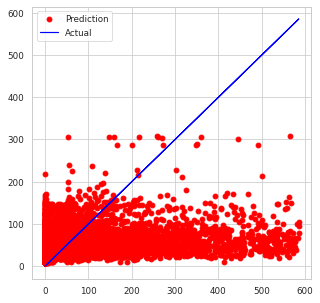

In [ ]:
model.evaluate(texts_val, val_y) 
#len(X_val)
#train_y.mean()

val_data['pred_claps_bigCNN'] = model.predict(texts_val)
fig, ax1 = plt.subplots(1, 1, figsize = (5, 5))
ax1.plot(val_data['totalClapCount'], val_data['pred_claps_bigCNN'], 'ro', label = 'Prediction')
ax1.plot(val_data['totalClapCount'], val_data['totalClapCount'], 'b-', label = 'Actual')
ax1.legend()

val_data.pred_claps_bigCNN.describe()

In [ ]:
print('complex CNN MAE:', metrics.mean_absolute_error(val_y, val_data['pred_claps_bigCNN']))
error = metrics.mean_absolute_error(val_y, val_data['pred_claps_bigCNN'])

mae.append(("ComplexCNN MAE", error))

coefficients = pd.concat([pd.DataFrame(X.columns),pd.DataFrame(np.transpose(regressor.coef_))], axis = 1)
coefficients

### Extracting prediction on test Data
test_predictions_bigCNN = model.predict(x_test)
test_predictions["bigCNN"] = test_predictions_bigCNN
print(test_predictions)

     Unnamed: 0      baseline       linear    miniCNN       stack     bigCNN
0             0  11925.742588  8863.408011  47.466293  268.755283  24.410152
1             1   3000.265492  2155.761287  37.669350  153.851006  19.173100
2             2   3379.266643  2521.084323  22.881779  222.461128  23.666241
3             3   1408.460660   977.399136  42.054787  155.255167  10.473527
4             4    404.107611   289.836423  35.079487  148.558397  12.147667
..          ...           ...          ...        ...         ...        ...
509         509   3474.016931  2559.949675  41.813400  160.223739  20.328026
510         510    498.857899   484.274815  62.019775  219.198526  13.174059
511         511    498.857899 -1472.864904  30.609410  158.492773  10.089076
512         512   2242.263191  1641.677255  26.714950  149.854546  13.663631
513         513    688.358474   512.331273  27.996592  148.882434  18.319433

[514 rows x 6 columns]


## Results

The results are difficult to evaluate. Looking at the errors and the prediction results does not give a great deal of confidence. 

Several factors can be named that might explain sub-standard results compared to other machine learning problems.

**The task** is both intriguing and difficult. Reliably predicting success of a blog post is every blogger's dream. The results show that modeling the phenomenon of virality, or even user engagement, is difficult. Many external factors might influence the success of a post, likely mixed with a fair bit of chance. Also, some of the variables such as responses here are not available when publishing. This in fact takes the one varible that reliably showed to be linked to the number of claps out of the equation.

**The data**, especially the test set, was lacking in explanative value. While the training data offered more features, the test data was very limited. Little overlapping with the train data made inference difficult, or at least incomplete.

**The process** has its own flaws. While many approaches were tried, the techniques used were applied in a rather broad but shallow fashion. Fewer, more thoroughly tuned models and increased training time would likely yield better results. This goes for the stacking ensemble which used basically untuned models, as well as for the neural nets which were not trained until convergence. It's possible that an approach with more iterations over fewer data would have made for better predictions.

Parameter choice in the language models is also important. For the complex CNN model, a large batch size was used. This should be refleted in changes to other parameters such as batch size, but was not.

It would have also been interesting to use headline data as well, as a headline is the first point of contact for any user. It might be decisive in the users decision to engage.

Again, it is still very much possible that using text data alone gives little information on future user engagement. There might be certain recipes to increase success, but these would likely be tough for an algorithm to detect.



### Choosing a model for prediction

The metric used to determine model performance was mean absolute error of predictions on the validation set. Going by this, the most promising model would be one of the simplest: The MAE of linear regression on the numeric features has an mae of 44,4.

Going by this, the choice is easy. But when looking at the predictions on the valitation set, some doubt is cast. The numbers look suspiciously large, given that the average and mean values of the total claps are rather small, and contain negative values as well.

The most realistic looking predictions, with an even spred, come from the simple CNN model.

Looking at correlations of the results, there is some postive correlation throughout, both for the predictions on the validation set, as well as between predictions on the test set.

Ultimately, an average across all predictions os built and used for the submission.

In [ ]:
val_data.to_csv('val_trained.csv')
test_predictions.to_csv('test_predictions_final.csv')

with open("mae.txt", "w") as output:
    output.write(str(mae))


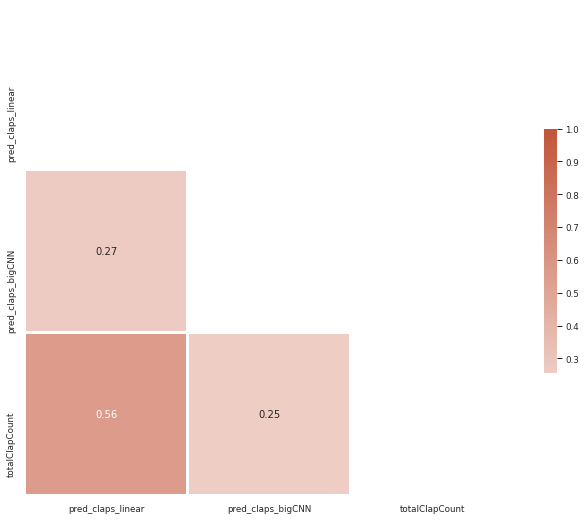

In [ ]:
# Compute the correlation matrix
temp = val_data[["pred_claps_linear", "pred_claps_bigCNN", "totalClapCount"]]


corr = temp.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True,mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": .5})

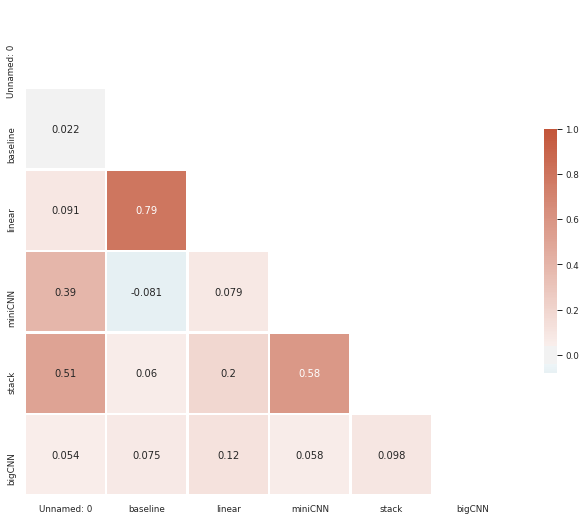

In [ ]:
# Compute the correlation matrix
temp = test_predictions


corr = temp.corr()


# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, annot=True,mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=1.5, cbar_kws={"shrink": .5})